# Characterize within-host variants

May 8, 2020

Kat and Gage have sequenced SARS-CoV2 from putative transmission pairs in Wisconsin. In this data, they see that there is a lot of shared within-host diversity between pairs, but that a lot of this diversity is also shared among non-transmission pairs of samples. This is concerning and a little weird. This was also observed in [this paper](https://www.medrxiv.org/content/10.1101/2020.04.24.20078691v1) that Gage found, although I have not read it closely. 

There are a few questions that I think would be nice to try to address by looking at the phylogeny: 

1. Are any of these recurrent within-host mutations also ones identified as problematic/likely errors by people looking at consensus data? If so, these should probably be excluded. I will use this virological post [here](http://virological.org/t/issues-with-sars-cov-2-sequencing-data/473)

2. How frequently do within-host variants appear in consensus sequences? I would hypothesize that the vast majority of within-host variation being generated is not particularly advantageous. In this scenario, we would expect to observe only a small fraction of these within-host variants on the phylogeny, and when we do, we expect them to be primarily observed at terminal nodes rather than on internal branches.

3. Do any of these within-host variants appear downstream at the consensus level from the host they were sampled in? By this I mean, if we observe a within-host variant in a particular person, is that infection upstream of later sampled cases? If so, is that variant detected at consensus level in any of those offspring infections? We will see. 


I think that for this analysis, it may be worthwhile to try to help them set up a Wisconsin-focused community build. This could use the new snakemake rules to generate a community build that focuses on Wisconsin but also pulls in sequences from elsewhere. This might be a nice thing to help facilitate and it would absolutely provide them with a better tree for inference than their current Wisconsin-only build. 

Kat mapped the genomes to this reference: MN908947.3.

This is a link to their local nextstrain build http://35.226.31.45/Wisconsin?branchLabel=aa&c=clade_membership&r=location

One note here is that indels are labelled differently in Kat's output files than in the nextstrain tree. In the nextstrain tree, `-505A` means that there was an A insertion at 505. `A505-` means that there was a deletion at 505. 

### Requirements: 
To run this, you will need to have all of the modules in the following block installed. You will also need to have the most recent version of baltic installed, which is available [here](https://github.com/evogytis/baltic/tree/master/docs).

In [50]:
import imp
import importlib, json
import glob
import re,copy,json
import requests
import pandas as pd 
import numpy as np
    
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [163]:
# define colors
s_color = "#A5CDA2"
ns_color = "#0E7908"
stop_color = "#073C04"
fs_color = "#00357D"
fs_stop_color = "#00142F"

## Read in vcfs and convert to dataframes 

I will only read in the intersection SNVs, meaning the ones that were detected in both technical sequencing replicates. This code will separate this into 2 dataframes, 1 for SNVs and 1 for indels, and will also look up and add in the strain names (necessary for converting from tube numbers, which is how the csvs are labelled). All of this code is contained in the ipython notebook called `vcf-module.ipynb`, which I am just going to import here. By running `return_dataframes`, this will collate all vcfs in the vcf directory, combine into a dataframe, and format that dataframe properly. 

In [65]:
"""to load in an ipython notebook as a module, just run the following. You will now have access to all of the 
functions written in that jupyter notebook"""

%run vcf-module.ipynb

In [66]:
"""now, input the strain names file/metadata file, the directory containing the vcfs, and return the dataframess"""

strain_names_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-metadata.tsv"
fasta_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-avrl.fasta"
clades_file = "/Users/lmoncla/src/ncov-WI-within-host/data/clades-file-2020-08-28.txt"
vcf_directory = "/Users/lmoncla/src/ncov-WI-within-host/data/vcfs-all/"
samples_to_ignore = ["N_transcript"]

snvs_only, indels_only, all_intersection_variants,metadata_dict = return_dataframes(strain_names_file, clades_file,vcf_directory,samples_to_ignore,fasta_file)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [67]:
snvs_only.head()

,Unnamed: 0,SNP,POS_x,rep1_percent,rep2_percent,frequency,sampleid,annotation,gene,nt_change,...,aa_site,wt_aa,mut_aa,nt_ref,nt_mut,nuc_muts,minor_frequency,consensus_base,minor_base,minor_nuc_muts
3,8,orf1ab_C>T_Ser2839Ser_synonymous,8782.0,0.9411,0.8919,0.91650,53,synonymous,orf1ab,C>T,...,2839,Ser,Ser,C,T,C8782T,0.08350,T,C,T8782C
6,15,orf1ab_T>G_Met4958Arg_missense,15137.0,0.0173,0.0129,0.01510,53,missense,orf1ab,T>G,...,4958,Met,Arg,T,G,T15137G,0.01510,T,G,T15137G
7,16,orf1ab_A>C_Thr4959Pro_missense,15139.0,0.0184,0.0219,0.02015,53,missense,orf1ab,A>C,...,4959,Thr,Pro,A,C,A15139C,0.02015,A,C,A15139C
8,17,orf1ab_G>T_Gln4962His_missense,15150.0,0.0259,0.0304,0.02815,53,missense,orf1ab,G>T,...,4962,Gln,His,G,T,G15150T,0.02815,G,T,G15150T
9,18,orf1ab_T>G_Leu4968Trp_missense,15167.0,0.0103,0.0109,0.01060,53,missense,orf1ab,T>G,...,4968,Leu,Trp,T,G,T15167G,0.01060,T,G,T15167G


In [68]:
snvs_to_query = set(snvs_only['minor_nuc_muts'])
indels_to_query = set(indels_only['minor_nuc_muts'])
all_variants_to_query = snvs_to_query.copy()
all_variants_to_query.update(indels_to_query)
print(len(snvs_to_query))
print(len(indels_to_query))
print(len(all_variants_to_query))

376
124
500


In [69]:
def return_number_variants_per_sample(df):
    # output number of SNVs per sample
    snvs_list = []
    total_snvs = 0

    for i in set(df['strain_name'].tolist()):
        x = df[df['strain_name'] == i]
        snvs_list.append(len(x))
        total_snvs += len(x)
        
        if len(x) == 82:
            print(i)
    
    mean_number_snvs = total_snvs/(len(snvs_list))
    nparray = np.asarray(snvs_list)
    stdev = nparray.std()
    median = np.median(nparray)
    percentile_95 = np.percentile(nparray,97.5)
    percentile_5 = np.percentile(nparray,2.5)
    max_snvs = max(snvs_list)
    min_snvs = min(snvs_list)
    print("mean and st dev: ",mean_number_snvs, stdev)
    print("median: ", median)
    print("95th percentile: ",percentile_5,percentile_95)
    print("max:",max_snvs, "min:",min_snvs)
    print(len(snvs_list))

In [70]:
print("snvs")
return_number_variants_per_sample(snvs_only)
print("indels")
return_number_variants_per_sample(indels_only)

snvs
mean and st dev:  9.446601941747574 6.365453110939475
median:  9.0
95th percentile:  2.0 17.450000000000003
max: 59 min: 1
103
indels
mean and st dev:  7.099009900990099 5.049271980647847
median:  7.0
95th percentile:  2.5 14.0
max: 49 min: 2
101


In [73]:
# count up all the snvs that are repeated
s = snvs_only['minor_nuc_muts'].value_counts().rename_axis('SNV').reset_index(name='counts')
i = indels_only['minor_nuc_muts'].value_counts().rename_axis('SNV').reset_index(name='counts')
i.head()

,SNV,counts
0,-6696T,99
1,-15965T,91
2,-18368T,83
3,-19983T,76
4,-28214T,62


In [154]:
def return_counts_of_variants(df):
    
    df_to_return = pd.DataFrame()
    
    for m in set(df['minor_nuc_muts'].tolist()):
        local_df = df[df['minor_nuc_muts'] == m]
        annotations = local_df['homopolymer'].tolist()

        total_count = len(local_df)
        count_in = annotations.count("in")
        count_not = annotations.count("not")
        count_adjacent = annotations.count("adjacent")
        count_no_consensus = annotations.count("consensus not available")

        x = pd.DataFrame.from_dict({"SNV":[m],"counts":[total_count],"classified_counts":[count_in],"class":["in_hp"]})
        y = pd.DataFrame.from_dict({"SNV":[m],"counts":[total_count],"classified_counts":[count_not],"class":["not_in_hp"]})
        z = pd.DataFrame.from_dict({"SNV":[m],"counts":[total_count],"classified_counts":[count_adjacent],"class":["adjacent"]})
        w = pd.DataFrame.from_dict({"SNV":[m],"counts":[total_count],"classified_counts":[count_no_consensus],"class":["no_consensus"]})

        df_to_return = df_to_return.append(x.append(y.append(z.append(w))))
        
        
    return(df_to_return)

In [155]:
s = return_counts_of_variants(snvs_only)
s = s.sort_values(by=['counts','SNV'], ascending=False)

i = return_counts_of_variants(indels_only)
i = i.sort_values(by=['counts','SNV'], ascending=False)

i.head()

,SNV,counts,classified_counts,class
0,-6696T,99,0,in_hp
0,-6696T,99,95,not_in_hp
0,-6696T,99,0,adjacent
0,-6696T,99,4,no_consensus
0,-15965T,91,0,in_hp


In [158]:
snvs_more_than_once = s[s['counts'] > 1]
order_of_snvs = snvs_more_than_once['SNV'].tolist()[::4]

indels_more_than_once = i[i['counts'] > 1]
order_of_indels = indels_more_than_once['SNV'].tolist()[::4]

print(order_of_snvs)
print(order_of_indels)

['A15139C', 'T15167G', 'T15137G', 'T3037C', 'C15141A', 'G15118T', 'G15150T', 'T14408C', 'G23403A', 'T20316C', 'A16381G', 'T25563G', 'T8782C', 'T25500G', 'C17877T', 'T18877C', 'C6696T', 'T20148C', 'G15168A', 'T14937C', 'T1059C', 'G11083T', 'A15133C', 'T7420C', 'C15354T', 'C15122T', 'C10619A', 'T3692G', 'T26124C', 'T2416C', 'G15965T', 'T3871G', 'G4838A', 'G1730A', 'C21575T', 'C15157A', 'T9195C', 'T6884G', 'G15131T', 'G13571T', 'C3931T', 'T6445C', 'T15144A', 'T11075C', 'G7929A', 'G20113T', 'G12578T', 'C7837A', 'C29627T', 'C29353T', 'C29077T', 'C28657T', 'C28253T', 'C22062T', 'C20115A', 'C20104T', 'C17172T', 'C15280T', 'C13541T', 'C12923T']
['-6696T', '-15965T', '-18368T', '-19983T', '-28214T', '-11812A', '-1135A', '-7889T', 'TCATGTTATGGTTG509-', '-10386T', '-26654T', '-23903T', '-27691T', '-13459T', '-10619A', 'CCCATTGGTGCAGGTATATGCGCTAGTT23554-', '-14625T', '-24223T', '-1813A', '-25797A', '-22062T', 'G15964-', '-8927T', '-6961T', '-5187T', '-22583T', '-19368T', '-17019T', '-13541T']


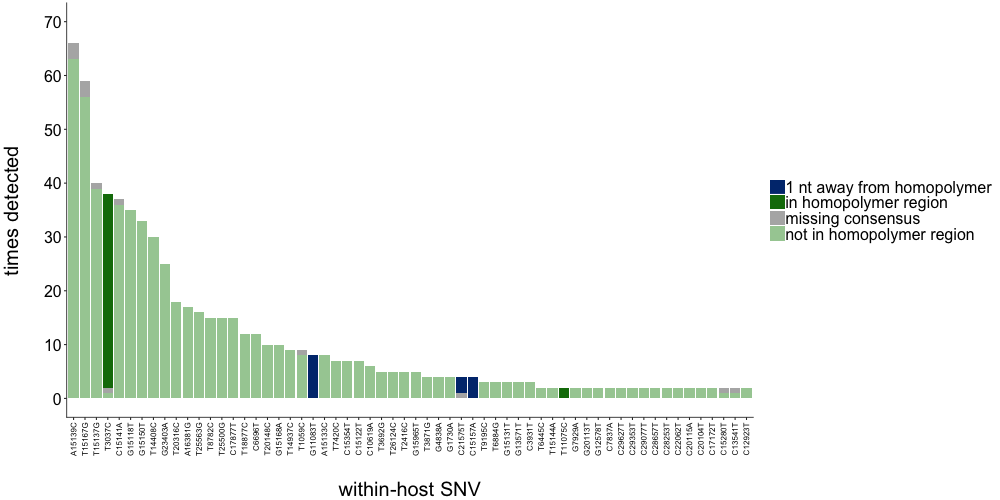

In [172]:
%%R -w 1000 -h 500 -u px -i snvs_more_than_once,s_color,ns_color,stop_color,fs_color,fs_stop_color,order_of_snvs # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

snvs_more_than_once$SNV_f = factor(snvs_more_than_once$SNV, levels=c(order_of_snvs))

p2 <- ggplot(snvs_more_than_once, aes(x=SNV_f, y=classified_counts, fill=class))+
    geom_col()+
    scale_fill_manual(values=c(in_hp=ns_color, not_in_hp=s_color,adjacent=fs_color,no_consensus="grey70"), labels=c(in_hp="in homopolymer region",not_in_hp="not in homopolymer region",adjacent="1 nt away from homopolymer",no_consensus="missing consensus"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,70), breaks=seq(0,70,10))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=1, vjust=0.5, size=8, angle=90,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host SNV",y="times detected\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave("counts-low-freq-snvs-2020-08-27.pdf", p2, width = 12, height = 4, path="/Users/lmoncla/src/ncov-WI-within-host/figures/")
p2

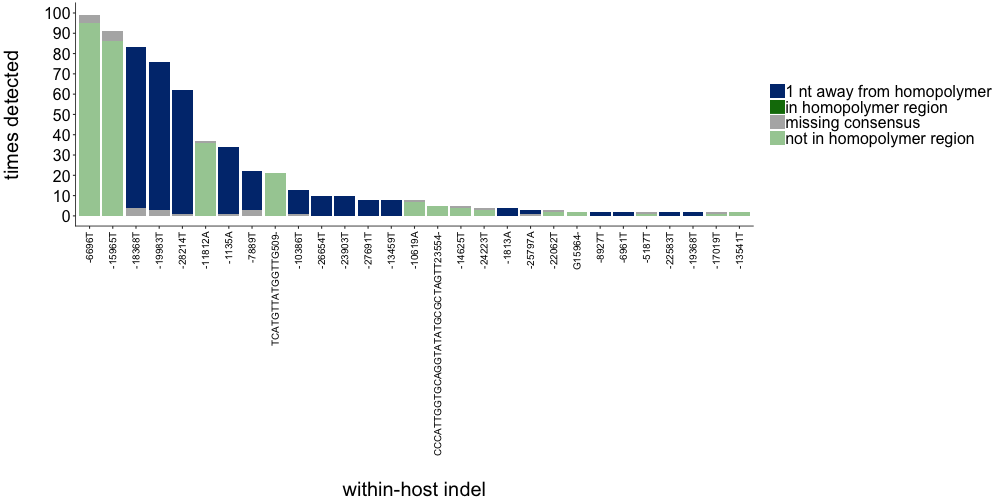

In [173]:
%%R -w 1000 -h 500 -u px -i indels_more_than_once,s_color,ns_color,stop_color,fs_color,fs_stop_color,order_of_indels # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

indels_more_than_once$SNV_f = factor(indels_more_than_once$SNV, levels=c(order_of_indels))

p3 <- ggplot(indels_more_than_once, aes(x=SNV_f, y=classified_counts, fill=class))+
    geom_col()+
    scale_color_manual(values=c(in_hp=ns_color, not_in_hp=s_color,adjacent=fs_color,no_annotation=fs_stop_color))+
    scale_fill_manual(values=c(in_hp=ns_color, not_in_hp=s_color,adjacent=fs_color,no_consensus="grey70"), labels=c(in_hp="in homopolymer region",not_in_hp="not in homopolymer region",adjacent="1 nt away from homopolymer",no_consensus="missing consensus"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,100), breaks=seq(0,100,10))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=1, vjust=0.5, size=10, angle=90,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host indel",y="times detected\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave("counts-low-freq-indels-2020-08-27.pdf", p3, width = 9, height = 8, path="/Users/lmoncla/src/ncov-WI-within-host/figures/")
p3

In [22]:
sloth = snvs_only[snvs_only['nuc_muts'] == 'G11083T']
#sloth

## Test to see whether any of the recurrent variants are in this dataset

Using the list of putative masked variants [here](http://virological.org/t/issues-with-sars-cov-2-sequencing-data/473), see if any of these sites are present in the within-host data. 

**They recommend this:**

*Secondly, we propose masking sites that appear to be highly homoplasic and have no phylogenetic signal and/or low prevalence – these can be recurrent artefacts, or otherwise hypermutable low-fitness sites that might similarly cause phylogenetic noise. A current list of these is:
187, 1059, 2094, 3037, 3130, 6990, 8022, 10323, 10741, 11074, 13408, 14786, 19684, 20148, 21137, 24034, 24378, 25563, 26144, 26461, 26681, 28077, 28826, 28854, 29700.
We provide technical details of how these sites were identified below, however please note that all lists of sites outlined here are a work in progress, and might be affected by many choices made in the preliminary phylogenetic steps.*

*In addition, we suggest masking any homoplasic positions that are exclusive to a single sequencing lab or geographic location, regardless of phylogenetic signal. Here the phylogenetic signal might be caused by a common source of error (among other things). Our current list is:
4050, 13402.*

*We also recommend masking of positions that, despite having strong phylogenetic signal, are also strongly homoplasic. These may be caused by hypermutability at certain positions, although it is hard to rule out any possibility for now. Our current list is:
11083, 15324, 21575*


This paragraph of that blog is particularly useful. They split up all of the consensus sequences into those generated by nanopore, Illumina, or by KU Leuven. This is what they found: 

*We re-analysed these 3 datasets individually using TreeTime. The most predominant homoplasies were common across technology and country, including G11083T, C16887T, C21575T and C15324T. Others were exclusive to Illumina (most remarkably C11074T, C6990T, C29353T, and C29774T) while others were exclusive to nanopore. Surprisingly dataset C contained more homoplasies than B (Figure 8), of which many are mutations only found in C (e.g. T13402G, A4050C, T13408C, T8022G, C3130T, T28785G). Each of these homoplasies could in principle also be caused by issues with phylogenetic inference, which itself can be affected by homoplasic substitutions.*

They also note that some of these recurrent mutations, like at 11083 and 11074 extend long homopolymer T regions. 11074 is also Illumina specific in their analysis. They note that 11083 reverts multiple times on the tree as well.

In [198]:
def return_de_Maio_classification(SNV):
    masked_sites = [187, 1059, 2094, 3037, 3130, 6990, 8022, 10323, 10741, 11074, 13408, 14786, 19684, 20148, 21137, 24034, 24378, 25563, 26144, 26461, 26681, 28077, 28826, 28854, 29700]
    lab_specific = [4050, 13402]
    homoplasic = [11083, 15324, 21575]
    illumina_specific = ["C11074T", "C6990T", "C29353T", "C29774T"]
    
    # remove all nondigits
    site = int(''.join(filter(str.isdigit, SNV)))
    if SNV in illumina_specific: 
        annotation = "illumina_specific"
    elif site in masked_sites: 
        annotation = "masked"
    elif site in lab_specific: 
        annotation = "lab_specific"
    elif site in homoplasic:
        annotation = "homoplasic"
    else:
        annotation = "none"
    
    return(annotation)

In [199]:
snvs_more_than_once['de_Maio_class'] = snvs_more_than_once['SNV'].apply(return_de_Maio_classification)
indels_more_than_once['de_Maio_class'] = indels_more_than_once['SNV'].apply(return_de_Maio_classification)

snvs_more_than_once.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SNV,counts,classified_counts,class,de_Maio_class
0,A15139C,66,0,in_hp,none
0,A15139C,66,63,not_in_hp,none
0,A15139C,66,0,adjacent,none
0,A15139C,66,3,no_consensus,none
0,T15167G,59,0,in_hp,none


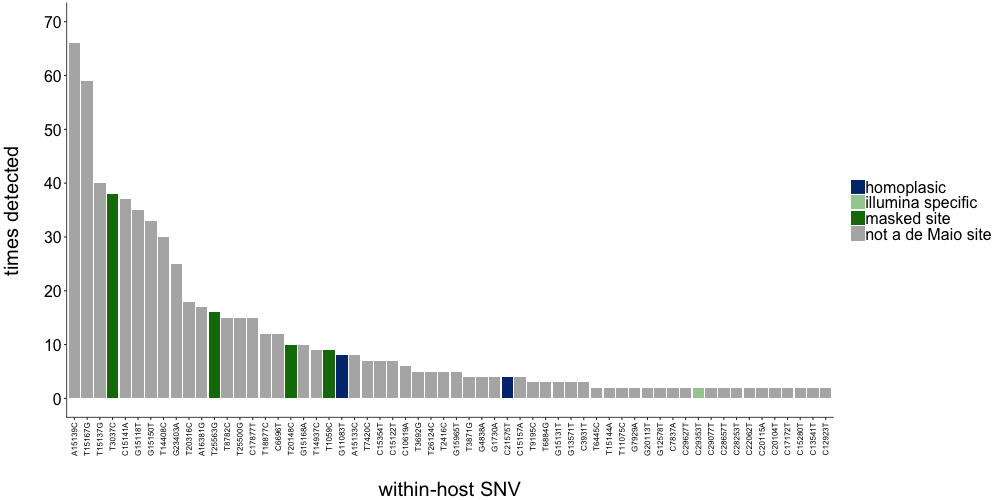

In [200]:
%%R -w 1000 -h 500 -u px -i snvs_more_than_once,s_color,ns_color,stop_color,fs_color,fs_stop_color,order_of_snvs # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

snvs_more_than_once$SNV_f = factor(snvs_more_than_once$SNV, levels=c(order_of_snvs))

p2 <- ggplot(snvs_more_than_once, aes(x=SNV_f, y=classified_counts, fill=de_Maio_class))+
    geom_col()+
    scale_fill_manual(values=c(masked=ns_color, lab_specific=s_color, illumina_specific=s_color,homoplasic=fs_color,none="grey70"), labels=c(masked="masked site",lab_specific="lab-specific variant",illumina_specific = "illumina specific", homoplasic="homoplasic",none="not a de Maio site"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,70), breaks=seq(0,70,10))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=1, vjust=0.5, size=8, angle=90,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host SNV",y="times detected\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave("counts-low-freq-snvs-de-maio-2020-09-03.pdf", p2, width = 12, height = 4, path="/Users/lmoncla/src/ncov-WI-within-host/figures/")
p2

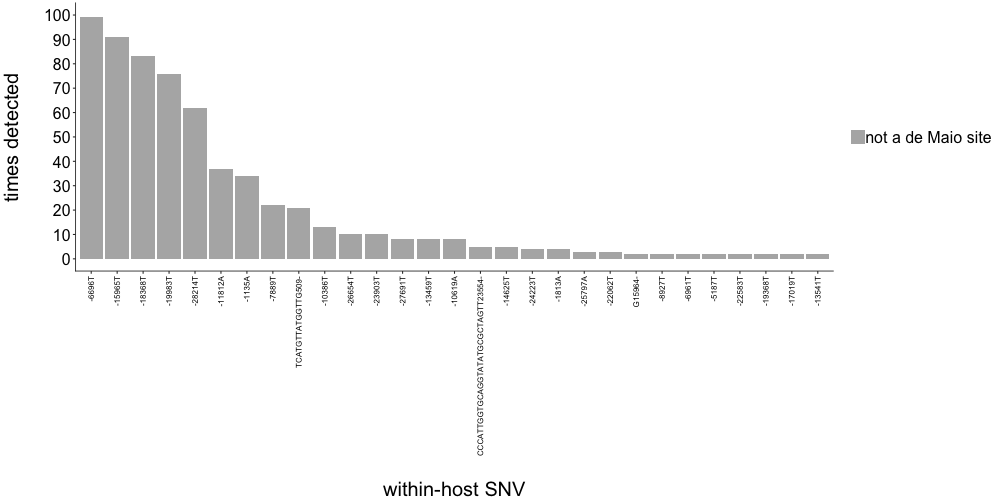

In [202]:
%%R -w 1000 -h 500 -u px -i indels_more_than_once,s_color,ns_color,stop_color,fs_color,fs_stop_color,order_of_indels # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

indels_more_than_once$SNV_f = factor(indels_more_than_once$SNV, levels=c(order_of_indels))

p2 <- ggplot(indels_more_than_once, aes(x=SNV_f, y=classified_counts, fill=de_Maio_class))+
    geom_col()+
    scale_fill_manual(values=c(masked=ns_color, lab_specific=s_color, illumina_specific=s_color,homoplasic=fs_color,none="grey70"), labels=c(masked="masked site",lab_specific="lab-specific variant",illumina_specific = "illumina specific", homoplasic="homoplasic",none="not a de Maio site"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,100), breaks=seq(0,100,10))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=1, vjust=0.5, size=8, angle=90,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host SNV",y="times detected\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave("counts-low-freq-indels-de-maio-2020-09-03.pdf", p2, width = 9, height = 8, path="/Users/lmoncla/src/ncov-WI-within-host/figures/")
p2

So...a lot of the shared variants do appear to be at these sites that they masked. There is a long thread in our slack about this, and Trevor does not seem to think that these are issues. I'm not really sure what to think to be honest. (link to slack: https://bedfordlab.slack.com/archives/CSKMU6YUC/p1589287709383400). 

After reading a bit more about this in detail, it seems like 11083 might just be a real, hypermutable spot. I think that given how well-characterized this within-host data is, that would be a nice addition to the literature (because they have duplicate sequencing and will have sequenced with 2 different methods). I find the Illumina specific mutations a little weird. I guess I do also wonder what is causing these specific mutations. Illumina sequencing has exceptionally low error rates and I would be shocked if these were induced by the sequencer itself. I would find it much more likely that this has to do with RT-PCR primers and cycling conditions. But not sure. 

## Plot a frequency distribution

I would really like to see a frequency distribution, because this would help me think about whether the patterns we see here are roughly neutral or not

In [222]:
def transform_percent(value: float):    
    if value <= 0.1:
        return('1-10%')
    elif value > 0.1 and value <=0.2: 
        return('10-20%')
    elif value > 0.2 and value <=0.3: 
        return('20-30%')
    elif value > 0.3 and value <=0.4: 
        return('30-40%')
    elif value > 0.4 and value <=0.5: 
        return('40-50%')
    elif value > 0.5 and value <=0.6: 
        return('50-60%')
    elif value > 0.6 and value <=0.7: 
        return('60-70%')
    elif value > 0.7 and value <=0.8: 
        return('70-80%')
    elif value > 0.8 and value <=0.9: 
        return('80-90%')
    elif value > 0.9 and value <=1.0: 
        return('90-100%')

In [223]:
def generate_frequency_bins(df):
    # assign bins to each SNP frequency value
    temp_df = pd.DataFrame(df)
    bin_series = df['minor_frequency'].apply(transform_percent)
    temp_df["bin"] = bin_series
    return(df)

In [224]:
def generate_counts_df(df):
    
    df_to_return = pd.DataFrame()
    
    for strain in set(df['strain_name'].tolist()):
        for mut_type in set(df['annotation'].tolist()):
            d = df[(df['strain_name'] == strain) & (df['annotation'] == mut_type)]
            d = d[['bin']]
            d = pd.DataFrame(d.groupby(['bin']).size())
            d.reset_index(inplace=True)
            d.columns = ['bin','count']
            total_snvs = d['count'].sum()
            d['proportion'] = d['count']/total_snvs
            d['strain_name'] = strain
            d['type'] = mut_type

            df_to_return = df_to_return.append(d)
    

    return(df_to_return)

In [225]:
# add in frequency bins and generate a counts dataframe
snvs_freq1 = generate_frequency_bins(snvs_only)
snvs_freq = generate_counts_df(snvs_freq1)
snvs_freq.head()

,bin,count,proportion,strain_name,type
0,1-10%,7,0.636364,USA/WI-UW-118/2020,synonymous
1,10-20%,2,0.181818,USA/WI-UW-118/2020,synonymous
2,20-30%,2,0.181818,USA/WI-UW-118/2020,synonymous
0,10-20%,3,0.750000,USA/WI-UW-118/2020,stop
1,20-30%,1,0.250000,USA/WI-UW-118/2020,stop


In [226]:
# repeat for indels
indels_freq1 = generate_frequency_bins(indels_only)
indels_freq = generate_counts_df(indels_freq1)
indels_freq.head()

,bin,count,proportion,strain_name,type
0,1-10%,2,1.000000,USA/WI-UW-118/2020,frameshift&stop
0,1-10%,28,0.595745,USA/WI-UW-118/2020,frameshift
1,10-20%,16,0.340426,USA/WI-UW-118/2020,frameshift
2,20-30%,1,0.021277,USA/WI-UW-118/2020,frameshift
3,30-40%,2,0.042553,USA/WI-UW-118/2020,frameshift


In [227]:
z = snvs_freq[snvs_freq['type'] == 'stop']
z

,bin,count,proportion,strain_name,type
0,10-20%,3,0.75,USA/WI-UW-118/2020,stop
1,20-30%,1,0.25,USA/WI-UW-118/2020,stop
0,1-10%,1,1.00,USA/WI-UW-232/2020,stop


### Calculate mean and standard errors

We really should have error bars on these plots

In [228]:
def fill_in_missing_values(values,sampling_value):
    missing_values = sampling_value - len(values)
    
    for i in range(missing_values):
        values.append(0.0)
    return(values)

In [229]:
def bootrap_values(values, iterations, sampling_value):
    bootstrapped_means = []
    
    for i in range(iterations):
        sample = np.random.choice(values, sampling_value, replace=True)
        mean = np.asarray(sample).mean()
        bootstrapped_means.append(mean)
    
    bootstrapped_means_array = np.array(bootstrapped_means)
    a = np.quantile(bootstrapped_means_array, 0.975)
    b = np.quantile(bootstrapped_means_array, 0.025)
    c = np.std(bootstrapped_means_array)
    
    return(a,b,c)

In [241]:
def run_bootstrap_iterations(df, iterations):
    
    freq_spec = pd.DataFrame()

    for p in set(df['type'].tolist()):
                    
        # I am setting sampling value down here because we only want to fill in missing bins for the type
        x = df[df['type'] == p]
        sampling_value = len(set(x['strain_name'].tolist()))

        for freq_bin in set(df['bin'].tolist()):

            d = df[(df['bin'] == freq_bin) & (df['type'] == p)]
            values = d['proportion'].tolist()

            values = fill_in_missing_values(values,sampling_value)
            mean = np.asarray(values).mean()
            a,b,c = bootrap_values(values, iterations, sampling_value)

            # generate dataframe 
            x = pd.DataFrame({"bin":[freq_bin],"type":[p],"mean":[mean],
                                "bootstrap_lower":[b],"bootstrap_upper":[a],"se_mean":[c]})
            freq_spec = freq_spec.append(x)
            
    return(freq_spec)

In [254]:
snvs_freq

,bin,count,proportion,strain_name,type
0,1-10%,7,0.636364,USA/WI-UW-118/2020,synonymous
1,10-20%,2,0.181818,USA/WI-UW-118/2020,synonymous
2,20-30%,2,0.181818,USA/WI-UW-118/2020,synonymous
0,10-20%,3,0.750000,USA/WI-UW-118/2020,stop
1,20-30%,1,0.250000,USA/WI-UW-118/2020,stop
0,1-10%,26,0.590909,USA/WI-UW-118/2020,missense
1,10-20%,14,0.318182,USA/WI-UW-118/2020,missense
2,20-30%,3,0.068182,USA/WI-UW-118/2020,missense
3,40-50%,1,0.022727,USA/WI-UW-118/2020,missense
0,1-10%,4,1.000000,USA/WI-UW-323/2020,synonymous


In [242]:
freq_spec_snvs = run_bootstrap_iterations(snvs_freq,1000)
freq_spec_snvs.head()

,bin,type,mean,bootstrap_lower,bootstrap_upper,se_mean
0,30-40%,synonymous,0.008183,0.000000,0.019834,0.005170
0,1-10%,synonymous,0.848562,0.788758,0.901500,0.029687
0,40-50%,synonymous,0.006796,0.000000,0.015210,0.003951
0,10-20%,synonymous,0.044079,0.021586,0.074429,0.013745
0,20-30%,synonymous,0.014710,0.000000,0.040600,0.010660


In [243]:
freq_spec_indels = run_bootstrap_iterations(indels_freq,1000)
freq_spec_indels.head()

,bin,type,mean,bootstrap_lower,bootstrap_upper,se_mean
0,10-20%,frameshift&stop,0.009901,0.000000,0.029703,0.009908
0,30-40%,frameshift&stop,0.000000,0.000000,0.000000,0.000000
0,20-30%,frameshift&stop,0.000000,0.000000,0.000000,0.000000
0,1-10%,frameshift&stop,0.811881,0.732673,0.881436,0.040796
0,10-20%,frameshift,0.013516,0.005101,0.023667,0.004888


In [244]:
freq_spec = freq_spec_snvs.append(freq_spec_indels)
freq_spec.head()

,bin,type,mean,bootstrap_lower,bootstrap_upper,se_mean
0,30-40%,synonymous,0.008183,0.000000,0.019834,0.005170
0,1-10%,synonymous,0.848562,0.788758,0.901500,0.029687
0,40-50%,synonymous,0.006796,0.000000,0.015210,0.003951
0,10-20%,synonymous,0.044079,0.021586,0.074429,0.013745
0,20-30%,synonymous,0.014710,0.000000,0.040600,0.010660


### Add in neutral expectation as a dashed line

The expectation for the proportion of variants in each frequency bin is given by a 1/x distribution. I will integrate the area under the curve for a 1/x distribution between each interval and plot this expected value. 

In [245]:
from scipy.integrate import quad

def integrate_over_bins(lower_bound,upper_bound):
    # generate lambda function for 1/x
    f= lambda x:(1/x)

    # integrate between bins 
    integral = quad(f, lower_bound, upper_bound)[0]
    return(integral)

In [246]:
def return_area_under_curve(bins):

    total_area_under_curve = 0
    integrals = []
    
    for i in range(len(bins)-1):
        lower_bound = bins[i]
        upper_bound = bins[i+1]
        integral = integrate_over_bins(lower_bound,upper_bound)
        integrals.append(integral)
        
    total_area_under_curve = np.asarray(integrals).sum()
    return(total_area_under_curve, integrals)

In [247]:
def return_neutral_expectation(total_area_under_curve, integrals):
    proportions = []
    for i in integrals: 
        proportion = i/total_area_under_curve
        proportions.append(proportion)
        
    return(proportions)

In [248]:
bins = [0.01,0.1,0.2,0.3,0.4,0.5]
#bins = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
total_area_under_curve, integrals = return_area_under_curve(bins)
proportions = return_neutral_expectation(total_area_under_curve, integrals)
neutral_df = pd.DataFrame({"bin":["1-10%","10-20%","20-30%","30-40%","40-50%"],"expected":proportions})
#neutral_df = pd.DataFrame({"bin":["1-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"],"expected":proportions})

types = []
for i in range(len(neutral_df)):
    types.append("missense")
for i in range(len(neutral_df)):
    types.append("synonymous")
for i in range(len(neutral_df)):
    types.append("stop")
for i in range(len(neutral_df)):
    types.append("frameshift")
for i in range(len(neutral_df)):
    types.append("frameshift&stop")
    
neutral_df = neutral_df.append(neutral_df).append(neutral_df).append(neutral_df).append(neutral_df)
neutral_df['type'] = types
neutral_df.head()

,bin,expected,type
0,1-10%,0.588592,missense
1,10-20%,0.177184,missense
2,20-30%,0.103646,missense
3,30-40%,0.073538,missense
4,40-50%,0.057040,missense


In [249]:
freq_spec_neutral = freq_spec.merge(neutral_df, on=["bin","type"], how="outer")
freq_spec_neutral = freq_spec_neutral.fillna(0)
freq_spec_neutral

,bin,type,mean,bootstrap_lower,bootstrap_upper,se_mean,expected
0,30-40%,synonymous,0.008183,0.000000,0.019834,0.005170,0.073538
1,1-10%,synonymous,0.848562,0.788758,0.901500,0.029687,0.588592
2,40-50%,synonymous,0.006796,0.000000,0.015210,0.003951,0.057040
3,10-20%,synonymous,0.044079,0.021586,0.074429,0.013745,0.177184
4,20-30%,synonymous,0.014710,0.000000,0.040600,0.010660,0.103646
5,30-40%,stop,0.000000,0.000000,0.000000,0.000000,0.073538
6,1-10%,stop,0.009709,0.000000,0.029126,0.009741,0.588592
7,40-50%,stop,0.000000,0.000000,0.000000,0.000000,0.057040
8,10-20%,stop,0.007282,0.000000,0.021845,0.007070,0.177184
9,20-30%,stop,0.002427,0.000000,0.007282,0.002299,0.103646


In [250]:
s_color = "#A5CDA2"
ns_color = "#0E7908"
stop_color = "#073C04"
fs_color = "#00357D"
fs_stop_color = "#00142F"

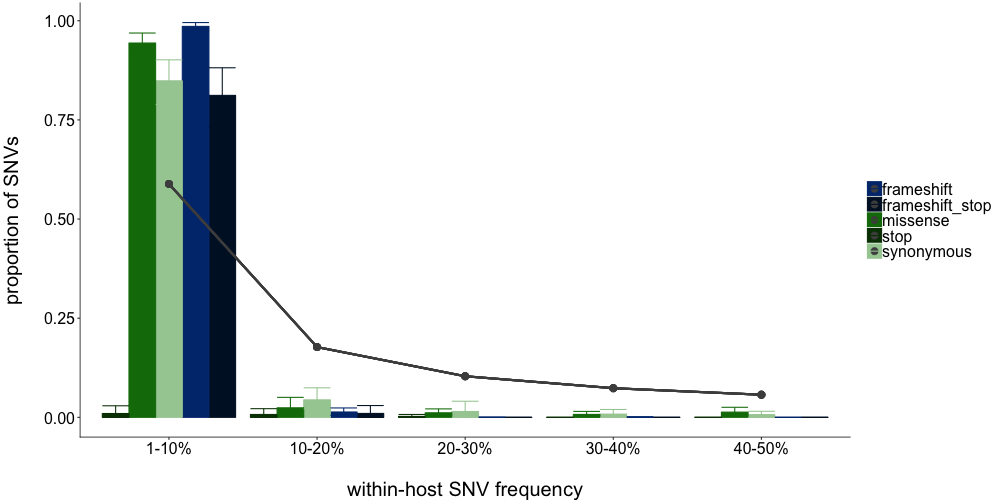

In [251]:
%%R -w 1000 -h 500 -u px -i freq_spec_neutral,s_color,ns_color,stop_color,fs_color,fs_stop_color # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

freq_spec_neutral$type <- gsub('&', '_', freq_spec_neutral$type)
freq_spec_neutral$typef = factor(freq_spec_neutral$type, levels=c("stop","missense","synonymous","frameshift","frameshift_stop"))

p3 <- ggplot(freq_spec_neutral, aes(x=bin, y=mean,color=type, fill=type, group=typef))+
    geom_col(position="dodge")+
    geom_point(data=freq_spec_neutral, aes(x=bin,y=expected), size=3, color="grey30")+
    geom_line(data=freq_spec_neutral, aes(x=bin,y=expected), linetype=1, size=1, color="grey30")+
    scale_color_manual(values=c(stop=stop_color, missense=ns_color, synonymous=s_color,frameshift=fs_color,frameshift_stop=fs_stop_color))+
    scale_fill_manual(values=c(stop=stop_color, missense=ns_color, synonymous=s_color,frameshift=fs_color,frameshift_stop=fs_stop_color))+
    geom_errorbar(data=freq_spec_neutral, aes(x=bin, ymin = bootstrap_lower, ymax = bootstrap_upper),position="dodge")+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=0.5, size=16, colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host SNV frequency",y="proportion of SNVs\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave("frequency-spectrum-low-freq-variants-2020-08-27.pdf", p3, width = 8, height = 4, path="/Users/lmoncla/src/ncov-WI-within-host/figures/")
p3

This looks to me very expected, where we have a large excess of low frequency variation, consistent with population expansion. It's actually pretty remarkable how similar the distributions are for synonymous and nonsynonymous variation. 